# EDA (Exploratory Data Analysis)

Performed by teammate Joanne Dong.

## Goal: Count spoken words in audio clips

If someone speaks slow, does it make sense to count the number of spoken words by pauses?
If someone speaks fast, does it make sense to count the number of spoken words by peaks?
Does having an accent alter how we should count spoken words?
Are there differences in speech fluidity between males and females?
How about by age?
Does the use of long words alter our count?

# Importing the data

In [1]:
import pandas as pd
import numpy as np

# training set
TR_df = pd.read_table("commonvoice/train/train.tsv")
TR_df = TR_df[["path","sentence"]]

# test set
TE_df = pd.read_table("commonvoice/test/test.tsv")
TE_df = TE_df[["path","sentence"]]

# validation set
VA_df = pd.read_table("commonvoice/validation/validation.tsv")
VA_df = TE_df[["path","sentence"]]

TR_df.head()

,path,sentence
0,common_voice_en_10110,I really liked the film we saw last week.
1,common_voice_en_10153,Please put maimi yajima's song onto Operación ...
2,common_voice_en_101622,Three men are painting a metal wall white.
3,common_voice_en_10187,"Though this be madness, yet there is method in it"
4,common_voice_en_10199,"As she watched, the cat washed his ears and th..."


## Add a column containing number of words in the sentence

In [2]:
def CountWordsText(in_str): # counts the number of words in a string
    return len(in_str.split(" "))

num_words_array = np.zeros(len(TR_df.sentence.values)) # storing number of words in an array first

for i in range(len(TR_df.sentence.values)):
    count = CountWordsText(TR_df.sentence.values[i])
    num_words_array[i] = count

num_words = pd.Series(num_words_array) # turn the array/list into a panda series

TR_df['num_words']=num_words # add the panda series to the data frame

TR_df.head() # check that the column was correctly added

,path,sentence,num_words
0,common_voice_en_10110,I really liked the film we saw last week.,9.0
1,common_voice_en_10153,Please put maimi yajima's song onto Operación ...,8.0
2,common_voice_en_101622,Three men are painting a metal wall white.,8.0
3,common_voice_en_10187,"Though this be madness, yet there is method in it",10.0
4,common_voice_en_10199,"As she watched, the cat washed his ears and th...",14.0


# Viewing the .WAV files

- Documentation for scipy.io.wavfile.read: https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html

- Documentation for scipy.fft():
https://docs.scipy.org/doc/scipy/tutorial/fft.html

- Documentation for scipy.fftfreq():
https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftfreq.html#scipy.fft.fftfreq

- Useful blog post for implementing scipy.fft(), fft() vs rff(): 
https://realpython.com/python-scipy-fft/#scipyfft-vs-scipyfftpack

In [3]:
# import stuff for .wav file analysis, plotting, and fast fourier transform
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from scipy.io import wavfile # get the api

In [4]:
# open an audio file from the training set
samplerate, data = wavfile.read('commonvoice/train/clips/common_voice_en_10110.wav')

length = data.shape[0]/samplerate
print(f"The clip has a duration of {length}s.")

The clip has a duration of 5.869s.


Text(0, 0.5, 'Amplitude')

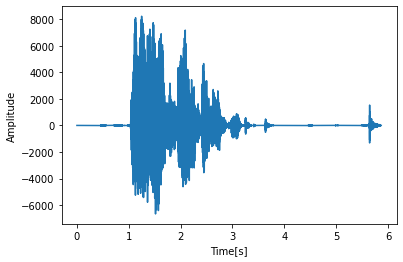

In [5]:
# plotting 
time = np.linspace(0, length, data.shape[0])
plt.plot(time, data)
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Power')

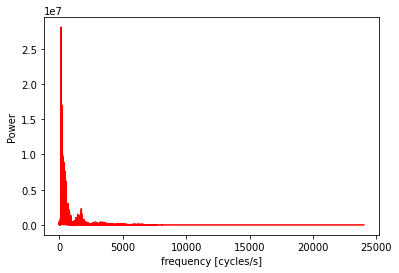

In [6]:
# now apply the Fourier transform to decompose into Fourier modes
freqdata = rfft(data)
timestep = length/data.shape[0]
xf = rfftfreq(data.shape[0], d=timestep)

plt.plot(xf,abs(freqdata), color='red')
plt.xlabel('frequency [cycles/s]')
plt.ylabel('Power')

<br>

## Repeat after normalization

In [7]:
TTV = ['train', 'test', 'validation']
main_dir = 'commonvoice'
data_ext = '.tsv'
data_sep = '\t'
aud_ext = '.wav'
clips = 'clips\\'

TR_dir = main_dir + '\\' + TTV[0] + '\\'
TE_dir = main_dir + '\\' + TTV[1] + '\\'
VA_dir = main_dir + '\\' + TTV[2] + '\\'

# Navigate directories (folders) and files.
import os

TR_dir = r"commonvoice\train\clips"
TR_aud = os.listdir(TR_dir)
TE_dir = r"commonvoice\test\clips"
TE_aud = os.listdir(TE_dir)
VA_dir = r"commonvoice\validation\clips"
VA_aud = os.listdir(VA_dir)


# Import the AudioSegment class for processing audio and the 
# split_on_silence function for separating out silent chunks.
import pydub
from pydub import AudioSegment
from pydub.silence import split_on_silence

def match_target_amplitude(aChunk, target_dBFS): # normalize audio to a target amplitude [decibels]
    change_in_dBFS = target_dBFS - aChunk.dBFS # normalize given audio chunk
    return aChunk.apply_gain(change_in_dBFS)

testclip = AudioSegment.from_wav(TR_dir+"\\"+TR_aud[0])
# match_target_amplitude(testclip,-15)

change_in_dBFS = -15 - testclip.dBFS
testclip = testclip.apply_gain(change_in_dBFS)